# UBS-seq Pipeline
## Basic Workflow

**C. Bryan Daniels**

**2/1/2024**

## Project: UBS-seq Basic Pipeline

The purpose of this project is run a minimally viable UBS-seq pipline. For simplicity, it will run several single-end samples, mapping only to the genome. The core steps of the pipeline are:
- cut_apapter
- quality_control
- align2ref
- sort2ref
- dedupe
- filter->all_multi_unique
- call_peaks
- select_groups
- analysis_and_annotation

This pipeline is based upon the paper by [Qing Dai, etal](https://doi.org/10.1038/s41587-023-02034-w) and the UBS-seq pipeline developed by [Chang Ye](https://github.com/y9c/m5C-UBSseq)



## Setup

#### The logic for the Pipeline is defined through a series of Steps using dirs to save intermediate results
1. For each **Step** in the pipeline a dir will be created and labeled **Step** and will contain all files created by that **Step**
2. Within a **Step**, **in_path** and **out_path** will generically refer to the prior and current **Step**
3. Within each **Step**, the appropriate processes will occur. Generally this involves processing files from **in_path** and saving to **out_path**
4. **Abbreviated filenames** should not change through the pipeline (suffixes will reflect current file formats). The dir name should reflect the **Step**, not the filename.
6. The function **mkpath(step)** returns a path for a dir **Step**. It will create a dir if need be, but not overwrite an existing dir
8. The function **fname(path,sample,suffix)** returns a file name without actually creating the file

#### Environment

In [1]:
import os, sys, subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from pathlib import Path
from IPython.display import display, HTML
from snakemake import load_configfile

In [2]:
def fname(path, base, sufix):
    'Return a path and suffix complete filename'
    return Path(path)/f"{base}.{sufix}"

def mkpath(path):
    'Return dir path name; creates (not over-writting) a new dir within the pwd'
    path = Path(path)
    if not os.path.exists(path): os.makedirs(path)
    return path

#### Path References

`Waring:` This notebook should be located and executed from within the directory `home_path/workspace/`

`Note:` Github ignores the data/, workspace/ and reference directories, except for `.py` and `.ipynb` files

In [654]:
home_path      = Path.cwd()/'..'
data_path      = home_path/'data'
workspace_path = home_path/'workspace'

Use `config.yaml` to configure `references/`, but not samples in `data/`

In [655]:
config = load_configfile("../config.yaml")

In [656]:
genome_fa  = home_path/config['reference']['genome']['fa'].removeprefix('~/')
genome_idx = home_path/config['reference']['genome']['hisat3n'].removeprefix('~/')

In [657]:
#genome_fa = ref_path/'genome/Homo_sapiens.GRCh38.genome.fa'
#genome_idx = ref_path/'index/hist3n/Homo_sapiens.GRCh38.genome'

In [658]:
# Add to shell PATH
os.environ['PATH'] = f"{str(home_path)}:" + os.environ['PATH'] # home_path
os.environ['PATH'] = '/home/cdaniels/bin/homer:' + os.environ['PATH'] # homer
os.environ['PATH'] = '/home/cdaniels/bin/hisat-3n:' + os.environ['PATH'] # hisat-3n

In [659]:
# Number of cores                                                                                                                                                                                               
nc = get_ipython().getoutput('nproc')                                                                                                                                                                           
nc = int(nc[0])                                                                                                                                                                                                 
nc  

32

#### Functions

In [9]:
def nlines(file):
    'Returns fast linecout (fast)'
    result = subprocess.run(['wc', '-l', file], stdout=subprocess.PIPE)
    n = int(result.stdout.split()[0])
    return n

In [10]:
def nseqs(bam_fastq):
    'Returns number of sequences in bam, sam, fasta or fastq file'
    n = !samtools view -c {bam_fastq}
    return int(n[0])

In [11]:
def samples_string(samples,path,suffix='bam'):
    'Returns a space delimited string of sample files'
    return " ".join([str(fname(path,sample,suffix)) for sample in samples])    

In [12]:
def make_table(ds1, ds2, ds1_name, ds2_name, y_label=None, xs_labels=None, table_label=None):
    'Makes a bar graph comparing two datasets and their corresponding names'
    assert(len(ds1)==len(ds2))
    n = np.arange(len(ds1))
    width = 0.35
    fig, ax = plt.subplots()
    rects1 = ax.bar(n - width/2, ds1, width, label=ds1_name)
    rects2 = ax.bar(n + width/2, ds2, width,label=ds2_name)
    ax.set_ylabel(y_label)
    ax.set_title(table_label)
    ax.set_xticks(n)
    ax.set_xticklabels(range(1,len(ds1)+1)) if xs_labels == None else ax.set_xticklabels(xs_labels)
    ax.legend()
    plt.show()

In [13]:
def make_histogram(ds, ds_name, table_label=None, y_label="Frequency", density=True):
    'Makes a histogram for a dataset and its name'
    fig, ax = plt.subplots()
    ax.hist(ds, density=density)
    ax.set_ylabel(y_label)
    ax.set_xlabel(ds_name)
    if table_label is not None:
        ax.set_title(table_label)
    plt.show()

## Step: select_samples

#### Select Samples and Filenames

In [71]:
out_path = mkpath('samples')

#### Project definitions for treated samples, control samples

In [72]:
# short sample names
treated = ["t1","t2","t3"] # Edit
control = [] # Edit
samples = treated + control

In [73]:
samples

['t1', 't2', 't3']

In [74]:
# sample filenames
samples_fn = [data_path/'test0_R1.fq.gz', data_path/'test1_R1.fq.gz', data_path/'test2_R1.fq.gz']

In [75]:
# dict
s2fn = {name: fname for (name,fname) in zip(samples,samples_fn)};
s2fn

{'t1': PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/test0_R1.fq.gz'),
 't2': PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/test1_R1.fq.gz'),
 't3': PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/test2_R1.fq.gz')}

In [81]:
for (s,fn) in s2fn.items():
    ! ln -s {data_path/fn} {fname(out_path,s,"fq.gz")}

Check that the files look correct

In [82]:
!ls  {out_path}

t1.fq.gz  t2.fq.gz  t3.fq.gz


How many sequence reads do we have per Sample

In [83]:
# Total Reads per Samples
files = [fname(out_path,sample, "fq.gz") for sample in samples]
for f in files:
    ns = nseqs(f)
    print(f"{f}: {ns:,}")

samples/t1.fq.gz: 935,632
samples/t2.fq.gz: 1,365,245
samples/t3.fq.gz: 1,183,321


## Step: fastqc_pre

#### Pre Trimming Quality Control

In [173]:
in_path = mkpath("samples")
out_path = mkpath("fastqc_pre")

#### fastqc

In [174]:
! fastqc --help


            FastQC - A high throughput sequence QC analysis tool

SYNOPSIS

	fastqc seqfile1 seqfile2 .. seqfileN

    fastqc [-o output dir] [--(no)extract] [-f fastq|bam|sam] 
           [-c contaminant file] seqfile1 .. seqfileN

DESCRIPTION

    FastQC reads a set of sequence files and produces from each one a quality
    control report consisting of a number of different modules, each one of 
    which will help to identify a different potential type of problem in your
    data.
    
    If no files to process are specified on the command line then the program
    will start as an interactive graphical application.  If files are provided
    on the command line then the program will run with no user interaction
    required.  In this mode it is suitable for inclusion into a standardised
    analysis pipeline.
    
    The options for the program as as follows:
    
    -h --help       Print this help file and exit
    
    -v --version    Print the version of the program and exit

##### paramaters:
- -o output dir

In [175]:
for sample in samples:
    ! fastqc {fname(in_path,sample,"fq.gz")} -o {out_path} 2> /dev/null

application/gzip
Analysis complete for t1.fq.gz
application/gzip
Analysis complete for t2.fq.gz
application/gzip
Analysis complete for t3.fq.gz


In [176]:
! ls {out_path}

t1_fastqc.html	t2_fastqc.html	t3_fastqc.html
t1_fastqc.zip	t2_fastqc.zip	t3_fastqc.zip


## Step: trimmed

#### Trim the adapter and downstream sequence as well as trimmng lower quality downstream sequence

In [543]:
in_path = mkpath("samples")
out_path = mkpath("trimmed")

In [545]:
adapter =  "AGATCGGAAGAGCACACGTCT"
barcode3 = "ATCACG"
#adapter = "AGATCGGAAGAGCACACGTCTGAACTCCAG"
#barcode3 = "TATCACGATCACG"

In [546]:
!ls {in_path}

t1.fq.gz  t1.fq.gz_trimming_report.txt	t2.fq.gz  t3.fq.gz


#### cutadapt

```
cutadapt -j {threads} 
            -n 2 
            -a "{params.barcode3}{params.adapter3};e=0.15;o=6;anywhere;" 
            --untrimmed-output={output.fastq_untrimmed} 
            -o - {input} 2>{output.report1} | 
cutadapt -j {threads} 
            -u 5 -u -5 
            --rename='{{id}}_{{cut_prefix}}{{cut_suffix}} {{comment}}' 
            --max-n=0 
            -q 15 
            --nextseq-trim=15 
            -m 20 
            --too-short-output={output.fastq_tooshort} 
            -o {output.fastq_cut} - >{output.report2}
```

https://cutadapt.readthedocs.io/en/stable/guide.html

In [547]:
! cutadapt --help

cutadapt version 4.6

Copyright (C) 2010 Marcel Martin <marcel.martin@scilifelab.se> and contributors

Cutadapt removes adapter sequences from high-throughput sequencing reads.

Usage:
    cutadapt -a ADAPTER [options] [-o output.fastq] input.fastq

For paired-end reads:
    cutadapt -a ADAPT1 -A ADAPT2 [options] -o out1.fastq -p out2.fastq in1.fastq in2.fastq

Replace "ADAPTER" with the actual sequence of your 3' adapter. IUPAC wildcard
characters are supported. All reads from input.fastq will be written to
output.fastq with the adapter sequence removed. Adapter matching is
error-tolerant. Multiple adapter sequences can be given (use further -a
options), but only the best-matching adapter will be removed.

Input may also be in FASTA format. Compressed input and output is supported and
auto-detected from the file name (.gz, .xz, .bz2). Use the file name '-' for
standard input/output. Without the -o option, output is sent to standard output.

Citation:

Marcel Martin. Cutadapt removes a

##### paramaters:
- -j 0, Number of CPU. Use 0 to autodetect
- --nextseq-trim=15, is used to trim these low-quality tails of 'G's by introducing a variable quality threshold
- --action=trim, trim adapter and downstream sequence
- -a '{barcode3}{adapter};e=0.15;o=6;anywhere;', 
- -n 2, Remove up to COUNT adapters from each read. Default: 1
- -u 5 -u -5, Remove LEN bases from each read. If positve, from beginning. If negative, from end
- --max-n=0, Discard reads with more than COUNT 'N' bases (here any)
- -q 15, Trim low-quality bases from 5' end of eachread before adapter removal.
- -m 20, Discard reads shorter than LEN
- --rename='{{id}}_{{cut_prefix}}{{cut_suffix}} {{comment}}', rename comment of fastq record
- --too-short-output={fname(out_path,sample,"fastq_tooshort")},
- -o {fname(out_path,sample,"fq.gz")}, output file
{fname(in_path,sample,"fq.gz")}, input file

In [548]:
for sample in samples:
    !cutadapt -j 0 --nextseq-trim=15 --action=trim -a '{barcode3}{adapter};e=0.15;o=6;anywhere;'\
            -n 2 -u 5 -u -5 --max-n=0 -q 15 -m 20 -l 80\
            --rename='{{id}}_{{cut_prefix}}{{cut_suffix}} {{comment}}'\
            --too-short-output={fname(out_path,sample,"fastq_tooshort")} \
            -o {fname(out_path,sample,"fq.gz")}  \
            {fname(in_path,sample,"fq.gz")} > {fname(out_path,sample,"log")}

Done           00:00:02     1,872,556 reads @   1.3 µs/read;  46.85 M reads/minute
Done           00:00:03     2,732,849 reads @   1.2 µs/read;  51.66 M reads/minute
Done           00:00:02     2,368,579 reads @   1.2 µs/read;  50.55 M reads/minute


#### Analysis

Take a look at a FASTQ file

In [549]:
in_fn  = fname(in_path,treated[0],'fq.gz')
out_fn = fname(out_path,treated[0],'fq.gz')
in_fn

PosixPath('samples/t1.fq.gz')

In [550]:
! zcat {in_fn}|head -16  

@SRR23538290.50 50 length=121
GGAAATTGTGGTAATTTTAGAGTTAATATATGTTGATGGGTGTTGATTTTTTTTGATGGTATCACGAGATCGGAAGAGCACACGTCTGAACTCCAGTCACCACTCAATCGCGTATTCCGTC
+
FFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF,FFFFF,FFF:F
@SRR23538290.52 52 length=121
CGTTGTTTATTGTTTGGGGGTTTTAGTTATTTTAGTGGAAGATGAATGATAAATCACGAGATCGGAAGAGCACACGTCTGAACTCCATACACCACTCAATCTCGTATGCATTCTTCTGCTT
+
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF,FF,FFFFFFFFF::FF:F,FFFF,FF:FFFFFFFF,FFFFF::FFF,:FFFFFF:FFF:FFFFFF:,F,,F,FF,FFF:F
@SRR23538290.144 144 length=121
TTTTTTTGGATATTAGGAAAAAATTTTGTAGAGAGAGTAAAAAATTTACTAGTATCACGAGATCGGAAGAGCACACGTCTGAACTCCAGTCACCACTCAATCTCGTATGCCGTCTTCTGCT
+
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFF:,FF,F:FFFFFF
@SRR23538290.203 203 length=121
GGCTATGTTGAAAATGAGATTAAGATAGTGTAATCACGAGATCGGAAGAGCACACGTCTGAACTCCAGTCACCACTCAATCTCGTATGCCGTCTTCTGCTTTAAAAGCTGGGGGGGGGGGG
+
FFFFFFFFFFFFF,

In [551]:
def show_adapter(reads):
    for read in reads.split('\n'):
        read = read.replace(adapter, f'<span style="color: blue;">{barcode3}{adapter}</span>')
        display(HTML(read))

Look for adapter in untrimmed reads

In [552]:
reads = ! zcat {in_fn} | head -36  | seqtk seq -A |grep -v '>'
reads = ('\n').join(reads)
show_adapter(reads)

Verify that adapters and all downstream elements of reads have been trimmed

In [553]:
reads = !zcat {out_fn}| head -256  | seqtk seq -A |grep -v '>'
reads = ('\n').join(reads)
show_adapter(reads)

What did `--rename='{{id}}_{{cut_prefix}}{{cut_suffix}} {{comment}}'` do?

Looks like 

In [554]:
!zcat {in_fn}| head -2 

@SRR23538290.50 50 length=121
GGAAATTGTGGTAATTTTAGAGTTAATATATGTTGATGGGTGTTGATTTTTTTTGATGGTATCACGAGATCGGAAGAGCACACGTCTGAACTCCAGTCACCACTCAATCGCGTATTCCGTC

gzip: stdout: Broken pipe


In [555]:
!zcat {out_fn}| head -2 

@SRR23538290.50_GGAAACCGTC 50 length=121
TTGTGGTAATTTTAGAGTTAATATATGTTGATGGGTGTTGATTTTTTTTGATGGT

gzip: stdout: Broken pipe


Verify that adapters and all downstream elements of reads have been trimmed

No reads should have been deleted with cutadapt. Veryify that number of reads before and after cutadapt are the same.

In [556]:
# Untrimmed
files = [fname(in_path,sample, "fq.gz") for sample in samples]
ins = [nseqs(f) for f in files]
ins

[1872556, 2732849, 2368579]

In [557]:
# Adapter Trimmed Reads
files = [fname(out_path,sample, "fq.gz") for sample in samples]
ins = [nseqs(f) for f in files]
ins

[1861617, 2712114, 2350874]

In [558]:
# Too Short Reads
files = [fname(out_path,sample, "fastq_tooshort") for sample in samples]
ins = [nseqs(f) for f in files]
ins

[10464, 20153, 17094]

Compare the sum of read lengths in the original and adapter trimmed files

In [559]:
files = [fname(in_path,sample, "fq.gz") for sample in samples]
res = []
for f in files:
    n = !seqtk seq -A {f}|grep -v '>'|wc -c
    res.append(int(n[0]))
ins = res
ins

[228451832, 333407578, 288966638]

In [560]:
files = [fname(out_path,sample, "fq.gz") for sample in samples]
res = []
for f in files:
    n = !seqtk seq -A {f}|grep -v '>'|wc -c
    res.append(int(n[0]))
outs = res
outs

[105937612, 142131260, 125540805]

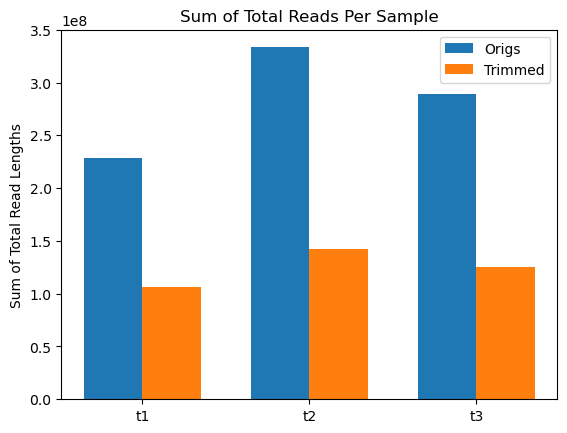

In [561]:
make_table(ins, outs, "Origs", "Trimmed", "Sum of Total Read Lengths", samples, "Sum of Total Reads Per Sample")

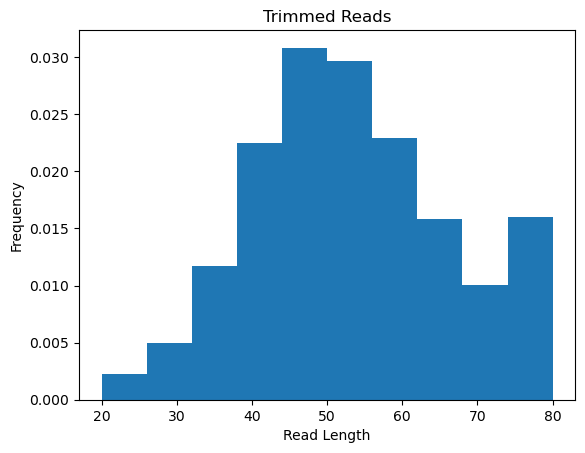

In [562]:
reads = !xargs zcat {out_path}/*.gz | seqtk seq -A  |grep -v ">" 
ds = [len(read) for read in reads]
make_histogram(ds, "Read Length", "Trimmed Reads")

## Step: fastqc_post

#### Post Trimming Quality Control

In [580]:
in_path = mkpath("trimmed")
out_path = mkpath("fastqc_post")

In [581]:
for sample in samples:
    ! fastqc {fname(in_path,sample,"fq.gz")} -o {out_path} 2> /dev/null

application/gzip
Analysis complete for t1.fq.gz
application/gzip
Analysis complete for t2.fq.gz
application/gzip
Analysis complete for t3.fq.gz


#### Consolidate fastqc Reports

In [587]:
!multiqc -f -fp -m fastqc -n multiqc -o {out_path} {out_path}


  /// ]8;id=511003;https://multiqc.info\MultiQC]8;;\ 🔍 | v1.19

|           multiqc | Only using modules: fastqc
|           multiqc | Search path : /home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/fastqc_post
|         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 7/7  0/7  
|            fastqc | Found 3 reports
|           multiqc | Report      : fastqc_post/multiqc.html
|           multiqc | Data        : fastqc_post/multiqc_data
|           multiqc | MultiQC complete


In [588]:
! ls {out_path}

multiqc_data  t1_fastqc.html  t2_fastqc.html  t3_fastqc.html
multiqc.html  t1_fastqc.zip   t2_fastqc.zip   t3_fastqc.zip


## Step: Hisat3n_align

#### Align Samples to Genome with Hisat-3n

In [682]:
in_path = mkpath("trimmed")
out_path = mkpath("hisat3n_align")

#### hisat-3n

http://daehwankimlab.github.io/hisat2/hisat-3n/

In [589]:
! hisat-3n --help

HISAT2 version 2.2.1-3n-0.0.3 by Daehwan Kim (infphilo@gmail.com, www.ccb.jhu.edu/people/infphilo)
Usage: 
  hisat2 [options]* -x <ht2-idx> {-1 <m1> -2 <m2> | -U <r>} [-S <sam>]

  <ht2-idx>  Index filename prefix (minus trailing .X.ht2).
  <m1>       Files with #1 mates, paired with files in <m2>.
             Could be gzip'ed (extension: .gz) or bzip2'ed (extension: .bz2).
  <m2>       Files with #2 mates, paired with files in <m1>.
             Could be gzip'ed (extension: .gz) or bzip2'ed (extension: .bz2).
  <r>        Files with unpaired reads.
             Could be gzip'ed (extension: .gz) or bzip2'ed (extension: .bz2).
  <sam>      File for SAM output (default: stdout)

  <m1>, <m2>, <r> can be comma-separated lists (no whitespace) and can be
  specified many times.  E.g. '-U file1.fq,file2.fq -U file3.fq'.

Options (defaults in parentheses):

 Input:
  -q                 query input files are FASTQ .fq/.fastq (default)
  --qseq             query input files are in Illumina's q

```
hisat3n --index {params.index}
        -p {threads}
        --summary-file {output.summary}
        --new-summary
        -q
        -U {input}
        --directional-mapping
        --base-change C,T
        --pen-noncansplice 20
        --mp 4,1
        --un {output.fq}
        -S {output.sam}
```

##### paramaters:
- --index {params.index}, Index filename prefix (minus trailing .X.ht2) 
- -p {nc}, number of threads
- --summary-file, print alignment summary to this file.
- --new-summary, print alignment summary in a new style, which is more machine-friendly.
- -q, query input files are FASTQ .fq/.fastq (default)
- -U {input}, 
- --directional-mapping, make directional mapping, please use this option only if your reads are prepared with a strand specific library (off)
- --base-change C,T,  the converted nucleotide and converted to nucleotide (C,T)
- --pen-noncansplice 20, penalty for a non-canonical splice site (12)
- --mp 4,1,  max and min penalties for mismatch; lower qual = lower penalty <6,2>
- --un {output.fq}, write unpaired reads that didn't align to <path> 
- -S {output.sam}, File for SAM output (default: stdout)

In [667]:
for sample in samples:
    !hisat-3n --index {genome_idx}\
        -p {nc}\
        --summary-file {fname(out_path,sample,"summary")}\
        --new-summary\
        -q\
        -U {fname(in_path,sample,'fq.gz')}\
        --directional-mapping\
        --base-change C,T\
        --pen-noncansplice 20\
        --mp 4,1\
        --un {fname(out_path,sample,'unmapped.fq')}\
        -S {fname(out_path,sample,'sam')}

HISAT2 summary stats:
	Total reads: 1861617
		Aligned 0 time: 377535 (20.28%)
		Aligned 1 time: 1211399 (65.07%)
		Aligned >1 times: 272683 (14.65%)
	Overall alignment rate: 79.72%
HISAT2 summary stats:
	Total reads: 2712114
		Aligned 0 time: 670236 (24.71%)
		Aligned 1 time: 1645757 (60.68%)
		Aligned >1 times: 396121 (14.61%)
	Overall alignment rate: 75.29%
HISAT2 summary stats:
	Total reads: 2350874
		Aligned 0 time: 566527 (24.10%)
		Aligned 1 time: 1444626 (61.45%)
		Aligned >1 times: 339721 (14.45%)
	Overall alignment rate: 75.90%


#### Analysis

In [679]:
!ls -lh {out_path}

total 2.6G
-rw-rw-r-- 1 cdaniels cdaniels 653M Jan 31 16:42 t1.sam
-rw-rw-r-- 1 cdaniels cdaniels  181 Jan 31 16:42 t1.summary
-rw-rw-r-- 1 cdaniels cdaniels  58M Jan 31 16:42 t1.unmapped.fq
-rw-rw-r-- 1 cdaniels cdaniels 905M Jan 31 16:43 t2.sam
-rw-rw-r-- 1 cdaniels cdaniels  181 Jan 31 16:43 t2.summary
-rw-rw-r-- 1 cdaniels cdaniels  97M Jan 31 16:43 t2.unmapped.fq
-rw-rw-r-- 1 cdaniels cdaniels 792M Jan 31 16:43 t3.sam
-rw-rw-r-- 1 cdaniels cdaniels  181 Jan 31 16:43 t3.summary
-rw-rw-r-- 1 cdaniels cdaniels  82M Jan 31 16:43 t3.unmapped.fq


In [683]:
! cat {out_path}/t1.summary

HISAT2 summary stats:
	Total reads: 1861617
		Aligned 0 time: 377535 (20.28%)
		Aligned 1 time: 1211399 (65.07%)
		Aligned >1 times: 272683 (14.65%)
	Overall alignment rate: 79.72%


In [676]:
! head -8 {out_path}/t1.unmapped.fq

@SRR23538290.1281_GTTTTGGGGG 1281 length=121
GTTTGGTTGATATTTTGAGTTTTTTTTGCACAT
+
,FFFFFF:FFFFFFFFFFFF:FFFFFFFFFFFF
@SRR23538290.1398_TACCTGGGGG 1398 length=121
GGGAATTTGTTATAAGTGTAGTGTATTCC
+
FFFFFFFFFFFFFFFFFFFFFFFFFFFFF


In [692]:
! grep -v '@' {out_path}/t1.sam |head -1

SRR23538290.1281_GTTTTGGGGG	4	*	0	0	*	*	0	0	GTTTGGTTGATATTTTGAGTTTTTTTTGCACAT	,FFFFFF:FFFFFFFFFFFF:FFFFFFFFFFFF	YT:Z:UU
grep: write error: Broken pipe


## Step: Hisat3n_sort

#### Sort and Index Hisat3n Sam Files

In [728]:
in_path = mkpath("hisat3n_align")
out_path = mkpath("hisat3n_sort")

#### samtools

http://www.htslib.org/doc/samtools.html

```
samtools view
    -@ {threads}
    -F4 -b {input} |
samtools sort
    -@ {threads}
    --write-index
    -m 4G
    -O BAM
    -o {output} -
```

##### paramaters:
```
samtools view, SAM<->BAM<->CRAM conversion
    -@ {nc}, number of threads 
    -F4, have none of the FLAGs present (-F 4 filters out unmapped reads) 
    -b, output a bam file
    {input}  |
samtools sort, sort alignment file
    -@ {nc}, number of threads
    --write-index, index the output files
    -O BAM, output file format
    -o {output} -
```

In [729]:
for sample in samples:
    ! samtools view -@ {nc} -F4 -b {fname(in_path, sample,'sam')}  | \
      samtools sort -@ {nc} --write-index -O BAM -o {fname(out_path,sample,'bam')} - 

[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...


#### Analysis

In [724]:
! ls -lh {out_path}

total 380M
-rw-rw-r-- 1 cdaniels cdaniels 2.7M Jan 31 20:33 t1.bai
-rw-rw-r-- 1 cdaniels cdaniels 102M Jan 31 20:35 t1.bam
-rw-rw-r-- 1 cdaniels cdaniels 2.7M Jan 31 20:35 t1.bam.bai
-rw-rw-r-- 1 cdaniels cdaniels 479K Jan 31 20:35 t1.bam.csi
-rw-rw-r-- 1 cdaniels cdaniels 3.0M Jan 31 20:33 t2.bai
-rw-rw-r-- 1 cdaniels cdaniels 138M Jan 31 20:35 t2.bam
-rw-rw-r-- 1 cdaniels cdaniels 3.0M Jan 31 20:35 t2.bam.bai
-rw-rw-r-- 1 cdaniels cdaniels 567K Jan 31 20:35 t2.bam.csi
-rw-rw-r-- 1 cdaniels cdaniels 2.9M Jan 31 20:33 t3.bai
-rw-rw-r-- 1 cdaniels cdaniels 122M Jan 31 20:35 t3.bam
-rw-rw-r-- 1 cdaniels cdaniels 2.9M Jan 31 20:35 t3.bam.bai
-rw-rw-r-- 1 cdaniels cdaniels 540K Jan 31 20:35 t3.bam.csi
-rw-rw-r-- 1 cdaniels cdaniels  16K Jan 31 19:22 umi.txt


## Step: Hisat3n_dedup

#### Remove Dulpicate Reads

In [730]:
in_path = mkpath("hisat3n_sort")
out_path = mkpath("hisat3n_dedup")

#### umicollapse

https://github.com/Daniel-Liu-c0deb0t/UMICollapse

##### paramaters:
```
umicollapse bam, use a bam file
    --two-pass, use a separate two-pass algorithm for SAM/BAM deduplication.
    -i {input.bam}, indexed input bam file
    -o {output.bam}, output bam file
      > {output.log}
```

In [731]:
for sample in samples:
    !umicollapse bam  \
    -i {fname(in_path,sample,'bam')} \
    -o {fname(out_path,sample,'bam')}\
    >  {fname(out_path,sample,'log')}

Picked up _JAVA_OPTIONS: -Xmx4096m
INFO	2024-01-31 20:42:47	SortingCollection	Creating merging iterator from 5 files
Picked up _JAVA_OPTIONS: -Xmx4096m
INFO	2024-01-31 20:43:06	SortingCollection	Creating merging iterator from 7 files
Picked up _JAVA_OPTIONS: -Xmx4096m
INFO	2024-01-31 20:43:27	SortingCollection	Creating merging iterator from 6 files


#### Analysis

In [732]:
! ls -h {out_path}

t1.bam	t1.log	t2.bam	t2.log	t3.bam	t3.log


## Step: dedup OLD OLD

#### Remove duplicate pcr reads

In [78]:
in_path= mkpath("align")
out_path = mkpath("dedup")

#### umi_tools

https://umi-tools.readthedocs.io/en/latest/index.html

pip install umi_tools

In [79]:
! umi_tools -h

For full UMI-tools documentation, see: https://umi-tools.readthedocs.io/en/latest/


umi_tools.py - Tools for UMI analyses

:Author: Tom Smith & Ian Sudbury, CGAT
:Tags: Genomics UMI

There are 6 tools:

  - whitelist
  - extract
  - group
  - dedup
  - count
  - count_tab

To get help on a specific tool, type:

    umi_tools <tool> --help

To use a specific tool, type::

    umi_tools <tool> [tool options] [tool arguments]



In [80]:
! umi_tools dedup


dedup - Deduplicate reads using UMI and mapping coordinates

Usage: umi_tools dedup [OPTIONS] [--stdin=IN_BAM] [--stdout=OUT_BAM]

       note: If --stdout is ommited, standard out is output. To
             generate a valid BAM file on standard out, please
             redirect log with --log=LOGFILE or --log2stderr 

For full UMI-tools documentation, see https://umi-tools.readthedocs.io/en/latest/

Required options missing, see --help for more details


##### paramaters
- dedup, deduplicate reads using UMI and mapping coordinates
- --method directional, specifies the algorithm used for selecting a representative read from a group of reads that share the same alignment position and UMI (after accounting for potential sequencing errors in the UMI).
- -I {in_fn}, indexed BAM file for deduplication
- --output-stats {stats_fn}, filename where the deduplication statistics will be saved
- -L {log_fn}, filename where log output should be written
- --temp-dir {temp_dir}, path to temporary directory
- S {out_fn}, stdout for BAM file with deduplicated reads

In [81]:
for sample in samples:
    !umi_tools dedup --method directional              \
        -I {fname(in_path,sample,"bam")}               \
        --output-stats={out_path}/dedup.stats          \
        -L {out_path}/umitools.log                     \
        --temp-dir={out_path}/                         \
        -S {fname(out_path,sample,"bam")} 2> /dev/null

In [82]:
! ls -lh {out_path}

total 324M
-rw-rw-r-- 1 cdaniels cdaniels  61M Oct 14 00:04 a4_1.bam
-rw-rw-r-- 1 cdaniels cdaniels  17M Oct 14 00:04 a4_2.bam
-rw-rw-r-- 1 cdaniels cdaniels  51M Oct 14 00:05 a4_3.bam
-rw-rw-r-- 1 cdaniels cdaniels  38M Oct 14 00:05 a4_4.bam
-rw-rw-r-- 1 cdaniels cdaniels  300 Oct 14 00:07 dedup.stats_edit_distance.tsv
-rw-rw-r-- 1 cdaniels cdaniels 1.4K Oct 14 00:07 dedup.stats_per_umi_per_position.tsv
-rw-rw-r-- 1 cdaniels cdaniels 1.5M Oct 14 00:07 dedup.stats_per_umi.tsv
-rw-rw-r-- 1 cdaniels cdaniels  42M Oct 14 00:06 no_1.bam
-rw-rw-r-- 1 cdaniels cdaniels  43M Oct 14 00:06 no_2.bam
-rw-rw-r-- 1 cdaniels cdaniels  31M Oct 14 00:07 no_3.bam
-rw-rw-r-- 1 cdaniels cdaniels  44M Oct 14 00:07 no_4.bam
-rw-rw-r-- 1 cdaniels cdaniels  36K Oct 14 00:07 umitools.log


#### Analysis

In [83]:
# Pre dedup
ins = [nseqs(fname(in_path,sample,'bam')) for sample in samples]
ins

[2595303, 819585, 1630323, 1176367, 1766129, 1290541, 967229, 1417404]

In [84]:
# Post dedup
outs = [nseqs(fname(out_path,sample,'bam')) for sample in samples]
outs

[1479247, 379872, 1263524, 919344, 978142, 997874, 767642, 1090610]

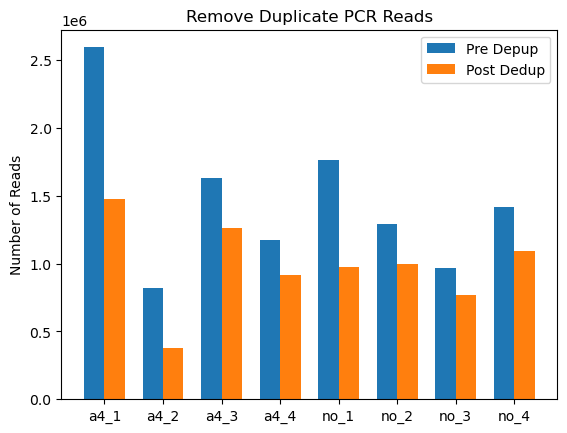

In [85]:
make_table(ins, outs, "Pre Depup", "Post Dedup", "Number of Reads", samples, "Remove Duplicate PCR Reads")

## Step: split_fwd

#### Split forward reads

In [86]:
in_path  = mkpath("dedup")
out_path = mkpath("split_fwd")

#### samtools view

https://www.htslib.org

In [87]:
!samtools view 


Usage: samtools view [options] <in.bam>|<in.sam>|<in.cram> [region ...]

Output options:
  -b, --bam                  Output BAM
  -C, --cram                 Output CRAM (requires -T)
  -1, --fast                 Use fast BAM compression (and default to --bam)
  -u, --uncompressed         Uncompressed BAM output (and default to --bam)
  -h, --with-header          Include header in SAM output
  -H, --header-only          Print SAM header only (no alignments)
      --no-header            Print SAM alignment records only [default]
  -c, --count                Print only the count of matching records
  -o, --output FILE          Write output to FILE [standard output]
  -U, --unoutput FILE, --output-unselected FILE
                             Output reads not selected by filters to FILE
  -p, --unmap                Set flag to UNMAP on reads not selected
                             then write to output file.
  -P, --fetch-pairs          Retrieve complete pairs even when outside of region

##### paramaters
- view,
- -@ {nc}, number of threads
- -F 16, excludes `flag 16`, meaning select forward reads (-f 16, selects reverse reads)
- -b,
- {in_fn}, input bam file 
- -o, ouput bam file with forward reads

#### samtools index

https://www.htslib.org

In [88]:
!samtools index

Usage: samtools index -M [-bc] [-m INT] <in1.bam> <in2.bam>...
   or: samtools index [-bc] [-m INT] <in.bam> [out.index]
Options:
  -b       Generate BAI-format index for BAM files [default]
  -c       Generate CSI-format index for BAM files
  -m INT   Set minimum interval size for CSI indices to 2^INT [14]
  -M       Interpret all filename arguments as files to be indexed
  -o FILE  Write index to FILE [alternative to <out.index> as an argument]
  -@ INT   Sets the number of threads [none]


##### paramters
- index, creates a bam index file for a bam file
- -@ {nc}, number of threads
- {in_fn}, input sorted bam file and ouputs an index; *.bam -> *.bam.bai

In [89]:
for sample in samples:
    !samtools view  -@ {nc} -F 16 {fname(in_path,sample,"bam")} -b -o {fname(out_path,sample,"bam")} 
    !samtools index -@ {nc} {fname(out_path,sample,"bam")}

In [90]:
!ls -lh {in_path}

total 324M
-rw-rw-r-- 1 cdaniels cdaniels  61M Oct 14 00:04 a4_1.bam
-rw-rw-r-- 1 cdaniels cdaniels  17M Oct 14 00:04 a4_2.bam
-rw-rw-r-- 1 cdaniels cdaniels  51M Oct 14 00:05 a4_3.bam
-rw-rw-r-- 1 cdaniels cdaniels  38M Oct 14 00:05 a4_4.bam
-rw-rw-r-- 1 cdaniels cdaniels  300 Oct 14 00:07 dedup.stats_edit_distance.tsv
-rw-rw-r-- 1 cdaniels cdaniels 1.4K Oct 14 00:07 dedup.stats_per_umi_per_position.tsv
-rw-rw-r-- 1 cdaniels cdaniels 1.5M Oct 14 00:07 dedup.stats_per_umi.tsv
-rw-rw-r-- 1 cdaniels cdaniels  42M Oct 14 00:06 no_1.bam
-rw-rw-r-- 1 cdaniels cdaniels  43M Oct 14 00:06 no_2.bam
-rw-rw-r-- 1 cdaniels cdaniels  31M Oct 14 00:07 no_3.bam
-rw-rw-r-- 1 cdaniels cdaniels  44M Oct 14 00:07 no_4.bam
-rw-rw-r-- 1 cdaniels cdaniels  36K Oct 14 00:07 umitools.log


#### Analysis

In [91]:
in_fn  = fname(in_path,treated[1], 'bam')
out_fn = fname(out_path,treated[1],'bam')
in_fn

PosixPath('dedup/a4_2.bam')

Look at the format of a bam file

In [92]:
!samtools view {in_fn} |head -2

VH01331:96:AACYNKFM5:1:2306:27131:33336_TTTTTTTA	16	chr1	405127	255	31M2D23M	*	0	0	GGGTAAAGAGGCAAAGAGGCACCTTTTATTTTTTTTTTTTTTTTTTTTTTGAGT	CCC--CC--CC;CCC---C--;--CC;-;CCCCCCCCCCCCCCCCCC;C;CCC;	NH:i:1	HI:i:1	AS:i:43	nM:i:2	NM:i:4	MD:Z:20T6C3^TC23	jM:B:c,-1	jI:B:i,-1
VH01331:96:AACYNKFM5:1:2606:44911:40284_TGCACAAC	16	chr1	607282	255	54M	*	0	0	GACAGAAAGGCAGGAGGAAGAGGAGGAGGAGAATCTTTGCACAGGGGGTGTCAG	C-CCCC---;CC-CC;;CCC-C;CCCCCC;CC;CCCCCC;CCCCCCCCCC-CCC	NH:i:1	HI:i:1	AS:i:53	nM:i:0	NM:i:0	MD:Z:54	jM:B:c,-1	jI:B:i,-1
samtools view: writing to standard output failed: Broken pipe
samtools view: error closing standard output: -1


Number of forward and reverse reads should equal total reads

In [93]:
!samtools view -c {in_fn} -F 16
!samtools view -c {in_fn} -f 16
!samtools view -c {in_fn}

233566
146306
379872


## Step: split_rev

#### Split reverse reads

In [95]:
in_path  = mkpath("dedup")
out_path = mkpath("split_rev")

#### samtools view

##### paramaters
- view,
- -@ {nc}, number of threads
- -F 16, excludes `flag 16`, meaning select forward reads (-f 16, selects reverse reads)
- -b,
- {in_fn}, input bam file 
- -o, ouput bam file with forward reads

#### samtools index

##### paramters
- index, creates a bam index file for a bam file
- -@ {nc}, number of threads
- {in_fn}, input sorted bam file and ouputs an index; *.bam -> *.bam.bai

In [96]:
for sample in samples:
    !samtools view  -@ {nc} -f 16 {fname(in_path,sample,"bam")} -b -o {fname(out_path,sample,"bam")} 
    !samtools index -@ {nc} {fname(out_path,sample,"bam")}

## Step: peak_fwd

#### Call peaks from forward reads

In [97]:
in_path   = mkpath("split_fwd")
out_path  = mkpath("peak_fwd")

#### macs3

https://macs3-project.github.io/MACS/

In [98]:
! macs3 callpeak -h

usage: macs3 callpeak [-h] -t TFILE [TFILE ...] [-c [CFILE ...]]
                      [-f {AUTO,BAM,SAM,BED,ELAND,ELANDMULTI,ELANDEXPORT,BOWTIE,BAMPE,BEDPE}]
                      [-g GSIZE] [-s TSIZE] [--keep-dup KEEPDUPLICATES]
                      [--outdir OUTDIR] [-n NAME] [-B] [--verbose VERBOSE]
                      [--trackline] [--SPMR] [--nomodel] [--shift SHIFT]
                      [--extsize EXTSIZE] [--bw BW] [--d-min D_MIN]
                      [-m MFOLD MFOLD] [--fix-bimodal] [-q QVALUE | -p PVALUE]
                      [--scale-to {large,small}] [--down-sample] [--seed SEED]
                      [--tempdir TEMPDIR] [--nolambda] [--slocal SMALLLOCAL]
                      [--llocal LARGELOCAL] [--max-gap MAXGAP]
                      [--min-length MINLEN] [--broad]
                      [--broad-cutoff BROADCUTOFF] [--cutoff-analysis]
                      [--call-summits] [--fe-cutoff FECUTOFF] [--to-large]
                      [--ratio RATIO] [--buffer-size BU

##### paramaters
- --treatment, space delimited list of treated sample bam files
- --control, space delimited list of control sample bam files
- -f BAM, file type is BAM
- -n fwd, prefix name for files
- -g hs, genome size, where hs means Homo sapiens (human) ~ 2.7e9
- --keep-dup all, how to handle duplicate tags aligned to the exact same position in the genome. all means don't discard any
- --outdir {out_path}, path of output
- --nomodel, do not build the shifting model from the data. The default is to model the shift size by considering distances reads positive and negative strands of reads
- --extsize 30, extend reads from 5' end by 30

Need a space delimted list of samples for **mac3**

In [99]:
print(samples_string(treated,in_path))
print(samples_string(control,in_path))

split_fwd/a4_1.bam split_fwd/a4_2.bam split_fwd/a4_3.bam split_fwd/a4_4.bam
split_fwd/no_1.bam split_fwd/no_2.bam split_fwd/no_3.bam split_fwd/no_4.bam


In [100]:
! macs3 callpeak                                  \
    --treatment {samples_string(treated,in_path)} \
    --control   {samples_string(control,in_path)} \
    -f BAM                                        \
    -n fwd                                        \
    -g hs                                         \
    --keep-dup all                                \
    --outdir {out_path}                           \
    --nomodel --extsize 30

INFO  @ 14 Oct 2023 00:13:43: [38 MB] 
# Command line: callpeak --treatment split_fwd/a4_1.bam split_fwd/a4_2.bam split_fwd/a4_3.bam split_fwd/a4_4.bam --control split_fwd/no_1.bam split_fwd/no_2.bam split_fwd/no_3.bam split_fwd/no_4.bam -f BAM -n fwd -g hs --keep-dup all --outdir peak_fwd --nomodel --extsize 30
# ARGUMENTS LIST:
# name = fwd
# format = BAM
# ChIP-seq file = ['split_fwd/a4_1.bam', 'split_fwd/a4_2.bam', 'split_fwd/a4_3.bam', 'split_fwd/a4_4.bam']
# control file = ['split_fwd/no_1.bam', 'split_fwd/no_2.bam', 'split_fwd/no_3.bam', 'split_fwd/no_4.bam']
# effective genome size = 2.91e+09
# band width = 300
# model fold = [5, 50]
# qvalue cutoff = 5.00e-02
# The maximum gap between significant sites is assigned as the read length/tag size.
# The minimum length of peaks is assigned as the predicted fragment length "d".
# Larger dataset will be scaled towards smaller dataset.
# Range for calculating regional lambda is: 1000 bps and 10000 bps
# Broad region calling is off
# Pa

#### Mark 6th column with a **+** to indicate a `fwd` peak (sed is 0 based)

In [101]:
!sed -i 's/\t[^\t]*/\t+/5' {out_path}/*.narrowPeak

In [102]:
!head -10 {out_path}/*.narrowPeak

chr1	629931	629961	fwd_peak_1	95	+	2.29353	14.6044	9.56511	4
chr1	630717	630752	fwd_peak_2	1066	+	2.4527	112.872	106.653	10
chr1	634027	634058	fwd_peak_3	142	+	1.36338	19.4755	14.2459	1
chr1	2059577	2059607	fwd_peak_4	93	+	7.27896	14.374	9.34693	9
chr1	7780948	7780978	fwd_peak_5	17	+	3.96276	6.17368	1.75758	0
chr1	11022187	11022217	fwd_peak_6	114	+	2.5373	16.5636	11.4402	5
chr1	11908168	11908218	fwd_peak_7	71	+	4.80762	12.0029	7.10054	8
chr1	20651168	20651198	fwd_peak_8	30	+	3.45782	7.60524	3.02988	2
chr1	23693852	23693908	fwd_peak_9	139	+	2.01178	19.1214	13.9047	5
chr1	24669246	24669316	fwd_peak_10	135	+	9.87106	18.7609	13.5553	62


## Step: peak_rev

#### Call peaks from reverse reads

In [103]:
in_path   = mkpath("split_rev")
out_path  = mkpath("peak_rev")

#### macs3

##### paramaters
- --treatment, space delimited list of treated sample bam files
- --control, space delimited list of control sample bam files
- -f BAM, file type is BAM
- -n fwd, prefix name for files
- -g hs, genome size, where hs means Homo sapiens (human) ~ 2.7e9
- --keep-dup all, how to handle duplicate tags aligned to the exact same position in the genome. all means don't discard any
- --outdir {out_path}, path of output
- --nomodel, do not build the shifting model from the data. The default is to model the shift size by considering distances reads positive and negative strands of reads
- --extsize 30, extend reads from 5' end by 30

Need a space delimted list of samples for **mac3**

In [104]:
print(samples_string(treated,in_path))
print(samples_string(control,in_path))

split_rev/a4_1.bam split_rev/a4_2.bam split_rev/a4_3.bam split_rev/a4_4.bam
split_rev/no_1.bam split_rev/no_2.bam split_rev/no_3.bam split_rev/no_4.bam


In [105]:
! macs3 callpeak                                  \
    --treatment {samples_string(treated,in_path)} \
    --control   {samples_string(control,in_path)} \
    -f BAM                                        \
    -n fwd                                        \
    -g hs                                         \
    --keep-dup all                                \
    --outdir {out_path}                           \
    --nomodel --extsize 30

INFO  @ 14 Oct 2023 00:14:38: [38 MB] 
# Command line: callpeak --treatment split_rev/a4_1.bam split_rev/a4_2.bam split_rev/a4_3.bam split_rev/a4_4.bam --control split_rev/no_1.bam split_rev/no_2.bam split_rev/no_3.bam split_rev/no_4.bam -f BAM -n fwd -g hs --keep-dup all --outdir peak_rev --nomodel --extsize 30
# ARGUMENTS LIST:
# name = fwd
# format = BAM
# ChIP-seq file = ['split_rev/a4_1.bam', 'split_rev/a4_2.bam', 'split_rev/a4_3.bam', 'split_rev/a4_4.bam']
# control file = ['split_rev/no_1.bam', 'split_rev/no_2.bam', 'split_rev/no_3.bam', 'split_rev/no_4.bam']
# effective genome size = 2.91e+09
# band width = 300
# model fold = [5, 50]
# qvalue cutoff = 5.00e-02
# The maximum gap between significant sites is assigned as the read length/tag size.
# The minimum length of peaks is assigned as the predicted fragment length "d".
# Larger dataset will be scaled towards smaller dataset.
# Range for calculating regional lambda is: 1000 bps and 10000 bps
# Broad region calling is off
# Pa

#### Mark 6th column with a **-** to indicate a `rev` peak (sed is 0 based)

In [106]:
!sed -i 's/\t[^\t]*/\t-/5' {out_path}/*.narrowPeak

In [107]:
!head -5 {out_path}/*.narrowPeak

chr1	1255454	1255484	fwd_peak_1	132	-	11.2836	18.3822	13.26	8
chr1	1543848	1543880	fwd_peak_2	203	-	2.71643	25.7131	20.375	22
chr1	1839165	1839198	fwd_peak_3	562	-	2.14733	62.1373	56.2356	26
chr1	8868002	8868036	fwd_peak_4	823	-	2.84089	88.4886	82.3552	27
chr1	11088120	11088151	fwd_peak_5	53	-	2.23231	10.1232	5.3919	28


## Step: peak_all

#### Combine the forward and reverese reads and extend peak sizes

In [146]:
in_fwd_path = mkpath("peak_fwd")
in_rev_path = mkpath("peak_rev")
out_path    = mkpath("peak_all")

In [147]:
!ls {out_path}

all.narrowPeak


##### Combine peaks

In [148]:
all_peaks    = out_path/"all.narrowPeak"

In [149]:
!cat {in_fwd_path}/*peaks.narrowPeak {in_rev_path}/*peaks.narrowPeak > {all_peaks}

In [150]:
!  wc -l {all_peaks} 

1484 peak_all/all.narrowPeak


##### Extend peaks by 20 nt in each direction

In [151]:
import pandas as pd
df = pd.read_csv(all_peaks, header = None, sep='\t')
df[:2]

,0,1,2,3,4,5,6,7,8,9
0,chr1,629931,629961,fwd_peak_1,95,+,2.29353,14.6044,9.56511,4
1,chr1,630717,630752,fwd_peak_2,1066,+,2.45270,112.8720,106.65300,10


In [152]:
df[1] = df[1]-20
df[2] = df[2]+20
df.to_csv(all_peaks, sep='\t', header=False,index=False)
df = pd.read_csv(all_peaks, header = None, sep='\t')
df[:2]

,0,1,2,3,4,5,6,7,8,9
0,chr1,629911,629981,fwd_peak_1,95,+,2.29353,14.6044,9.56511,4
1,chr1,630697,630772,fwd_peak_2,1066,+,2.45270,112.8720,106.65300,10


In [153]:
!head -10 {all_peaks}

chr1	629911	629981	fwd_peak_1	95	+	2.29353	14.6044	9.56511	4
chr1	630697	630772	fwd_peak_2	1066	+	2.4527	112.872	106.653	10
chr1	634007	634078	fwd_peak_3	142	+	1.36338	19.4755	14.2459	1
chr1	2059557	2059627	fwd_peak_4	93	+	7.27896	14.374	9.34693	9
chr1	7780928	7780998	fwd_peak_5	17	+	3.96276	6.17368	1.75758	0
chr1	11022167	11022237	fwd_peak_6	114	+	2.5373	16.5636	11.4402	5
chr1	11908148	11908238	fwd_peak_7	71	+	4.80762	12.0029	7.10054	8
chr1	20651148	20651218	fwd_peak_8	30	+	3.45782	7.60524	3.02988	2
chr1	23693832	23693928	fwd_peak_9	139	+	2.01178	19.1214	13.9047	5
chr1	24669226	24669336	fwd_peak_10	135	+	9.87106	18.7609	13.5553	62


## Step: call motif

#### Find motifs from peaks

In [154]:
in_path =  mkpath("peak_all")
out_path = mkpath("motif")

#### Homer

http://homer.ucsd.edu/homer/introduction/install.html

Install **homer** :
- wget http://homer.ucsd.edu/homer/configureHomer.pl
- mv configureHomer.pl homer/.
- chmod +x configureHomer.pl
- ./configureHomer.pl -install
- ./configureHomer.pl -install hg19
- Update .bashrc to include homer/run in $PATH

In [155]:
!findMotifsGenome.pl -h


	Program will find de novo and known motifs in regions in the genome

	Usage: findMotifsGenome.pl <pos file> <genome> <output directory> [additional options]
	Example: findMotifsGenome.pl peaks.txt mm8r peakAnalysis -size 200 -len 8

	Possible Genomes:
		hg38	human
			-- or --
		Custom: provide the path to genome FASTA files (directory or single file)
			Heads up: will create the directory "preparsed/" in same location.

	Basic options:
		-mask (mask repeats/lower case sequence, can also add 'r' to genome, i.e. mm9r)
		-bg <background position file> (genomic positions to be used as background, default=automatic)
			removes background positions overlapping with target positions unless -keepOverlappingBg is used
			-chopify (chop up large background regions to the avg size of target regions)
		-len <#>[,<#>,<#>...] (motif length, default=8,10,12) [NOTE: values greater 12 may cause the program
			to run out of memory - in these cases decrease the number of sequences analyzed (-N),
			or 

##### paramaters
- {in_fn}, file containing all.narrowPeak
- {out_path}, output dir
- hg38, use hg38 human genome
- p {nc}, number of processors
- rna, output RNA motif logos and compare to RNA motif database, automatically sets -norevopp
- S 10, number of motifs to optimize, default: 20
- -len 5,6,7,8,9,10, motif length, default=8,10,12
- bg {genome_bed12}, background position file; removes background positions overlapping with target positions 

In [157]:
# -S 10 is changed to -S {nc} = 32
# -len 5,6,7,8,9
# -bg {genome_bed12}
!findMotifsGenome.pl {in_path}/all.narrowPeak hg38 {out_path} \
                     -p {nc}                                  \
                     -rna                                     \
                     -len 5,6,7,8,9                           \
                     -bg {genome_bed12}


	Position file = peak_all/all.narrowPeak
	Genome = hg38
	Output Directory = motif
	Using 32 CPUs
	Operating in RNA mode
	Motif length set at 5,6,7,8,9,
	background position file: /home/cdaniels/uofc_data/ref/homo_sapian_39/gencode.v39.annotation.bed12
	Found mset for "human", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 1484
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 1484
		Redundant Peak IDs: 687
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Redunant Peaks found: Remove or rename these or some programs may have trouble...

	687 duplicate peak IDs out of 1484 total peaks
	Peak/BED file conversion summary:
		BED/Header formatted lines: 244939
		peakfile formatted lines: 0
	Max distance to merge: 200 bp
	Calculating co-bound peaks relative to reference: moti

#### Analysis

In [158]:
!ls -lh {out_path}

total 264K
-rw-rw-r-- 1 cdaniels cdaniels  25K Oct 14 00:45 0.0830720188832892.2.tmp.coBoundBy1.txt
-rw-rw-r-- 1 cdaniels cdaniels  25K Oct 14 00:27 0.311316585707576.2.tmp.coBoundBy1.txt
-rw-rw-r-- 1 cdaniels cdaniels  31K Oct 14 00:51 homerMotifs.all.motifs
-rw-rw-r-- 1 cdaniels cdaniels 3.0K Oct 14 00:47 homerMotifs.motifs5
-rw-rw-r-- 1 cdaniels cdaniels 4.7K Oct 14 00:47 homerMotifs.motifs6
-rw-rw-r-- 1 cdaniels cdaniels 5.1K Oct 14 00:48 homerMotifs.motifs7
-rw-rw-r-- 1 cdaniels cdaniels 8.6K Oct 14 00:49 homerMotifs.motifs8
-rw-rw-r-- 1 cdaniels cdaniels 9.2K Oct 14 00:51 homerMotifs.motifs9
drwxrwxr-x 2 cdaniels cdaniels  12K Oct 14 00:51 homerResults
-rw-rw-r-- 1 cdaniels cdaniels 112K Oct 14 00:51 homerResults.html
-rw-rw-r-- 1 cdaniels cdaniels  144 Oct 14 00:45 motifFindingParameters.txt
-rw-rw-r-- 1 cdaniels cdaniels 1.9K Oct 14 00:45 seq.autonorm.tsv


**Warning:** Motif Results are not fully rendered in Jupyter. A browser is better.

In [159]:
from IPython.display import HTML
HTML(filename=out_path/"homerResults.html")

# Combination Analysis

In [554]:
# Original bbbreviated sample names
#treated = ["a4_1","a4_2","a4_3","a4_4"] # Edit
#control = ["no_1","no_2","no_3","no_4"] # Edit

In [555]:
#Original samples
#samples = treated + control
#samples

In [730]:
# Use these for creating combinations
treated = ["a4_1","a4_2","a4_3","a4_4"]
control = ["no_1","no_2","no_3","no_4"]
samples = treated + control
tag = "1234@10-12-14" # Tags should be of form: "1", "234", "12_12", "1_12; 1234@10-12-14 means samples 1,2,3,4 w/len=10-12-14"

###############
tag = "_" + tag
print(treated)
print(control)
print(samples)
print(tag)

['a4_1', 'a4_2', 'a4_3', 'a4_4']
['no_1', 'no_2', 'no_3', 'no_4']
['a4_1', 'a4_2', 'a4_3', 'a4_4', 'no_1', 'no_2', 'no_3', 'no_4']
_1234@10-12-14


## Step: peak_fwd

#### Call peaks from forward reads

In [731]:
in_path   = mkpath("split_fwd")
out_path  = mkpath(f"peak_fwd{tag}")

In [732]:
print(out_path)

peak_fwd_1234@10-12-14


In [733]:
print(samples_string(treated,in_path))
print(samples_string(control,in_path))

split_fwd/a4_1.bam split_fwd/a4_2.bam split_fwd/a4_3.bam split_fwd/a4_4.bam
split_fwd/no_1.bam split_fwd/no_2.bam split_fwd/no_3.bam split_fwd/no_4.bam


In [734]:
! macs3 callpeak                                  \
    --treatment {samples_string(treated,in_path)} \
    --control   {samples_string(control,in_path)} \
    -f BAM                                        \
    -n fwd                                        \
    -g hs                                         \
    --keep-dup all                                \
    --outdir {out_path}                           \
    --nomodel --extsize 30

INFO  @ 14 Oct 2023 05:24:02: [61 MB] 
# Command line: callpeak --treatment split_fwd/a4_1.bam split_fwd/a4_2.bam split_fwd/a4_3.bam split_fwd/a4_4.bam --control split_fwd/no_1.bam split_fwd/no_2.bam split_fwd/no_3.bam split_fwd/no_4.bam -f BAM -n fwd -g hs --keep-dup all --outdir peak_fwd_1234@10-12-14 --nomodel --extsize 30
# ARGUMENTS LIST:
# name = fwd
# format = BAM
# ChIP-seq file = ['split_fwd/a4_1.bam', 'split_fwd/a4_2.bam', 'split_fwd/a4_3.bam', 'split_fwd/a4_4.bam']
# control file = ['split_fwd/no_1.bam', 'split_fwd/no_2.bam', 'split_fwd/no_3.bam', 'split_fwd/no_4.bam']
# effective genome size = 2.91e+09
# band width = 300
# model fold = [5, 50]
# qvalue cutoff = 5.00e-02
# The maximum gap between significant sites is assigned as the read length/tag size.
# The minimum length of peaks is assigned as the predicted fragment length "d".
# Larger dataset will be scaled towards smaller dataset.
# Range for calculating regional lambda is: 1000 bps and 10000 bps
# Broad region calli

#### Mark 6th column with a **+** to indicate a `fwd` peak (sed is 0 based)

In [735]:
!sed -i 's/\t[^\t]*/\t+/5' {out_path}/*.narrowPeak

## Step: peak_rev

#### Call peaks from reverse reads

In [736]:
in_path   = mkpath("split_rev")
out_path  = mkpath(f"peak_rev{tag}")

In [737]:
print(samples_string(treated,in_path))
print(samples_string(control,in_path))

split_rev/a4_1.bam split_rev/a4_2.bam split_rev/a4_3.bam split_rev/a4_4.bam
split_rev/no_1.bam split_rev/no_2.bam split_rev/no_3.bam split_rev/no_4.bam


In [738]:
! macs3 callpeak                                  \
    --treatment {samples_string(treated,in_path)} \
    --control   {samples_string(control,in_path)} \
    -f BAM                                        \
    -n fwd                                        \
    -g hs                                         \
    --keep-dup all                                \
    --outdir {out_path}                           \
    --nomodel --extsize 30

INFO  @ 14 Oct 2023 05:24:12: [61 MB] 
# Command line: callpeak --treatment split_rev/a4_1.bam split_rev/a4_2.bam split_rev/a4_3.bam split_rev/a4_4.bam --control split_rev/no_1.bam split_rev/no_2.bam split_rev/no_3.bam split_rev/no_4.bam -f BAM -n fwd -g hs --keep-dup all --outdir peak_rev_1234@10-12-14 --nomodel --extsize 30
# ARGUMENTS LIST:
# name = fwd
# format = BAM
# ChIP-seq file = ['split_rev/a4_1.bam', 'split_rev/a4_2.bam', 'split_rev/a4_3.bam', 'split_rev/a4_4.bam']
# control file = ['split_rev/no_1.bam', 'split_rev/no_2.bam', 'split_rev/no_3.bam', 'split_rev/no_4.bam']
# effective genome size = 2.91e+09
# band width = 300
# model fold = [5, 50]
# qvalue cutoff = 5.00e-02
# The maximum gap between significant sites is assigned as the read length/tag size.
# The minimum length of peaks is assigned as the predicted fragment length "d".
# Larger dataset will be scaled towards smaller dataset.
# Range for calculating regional lambda is: 1000 bps and 10000 bps
# Broad region calli

#### Mark 6th column with a **-** to indicate a `rev` peak (sed is 0 based)

In [739]:
!sed -i 's/\t[^\t]*/\t-/5' {out_path}/*.narrowPeak

## Step: peak_all

#### Combine the forward and reverese reads and extend peak sizes

In [740]:
in_fwd_path = mkpath(f"peak_fwd{tag}")
in_rev_path = mkpath(f"peak_rev{tag}")
out_path    = mkpath(f"peak_all{tag}")

##### Combine peaks

In [741]:
all_peaks    = out_path/"all.narrowPeak"

In [742]:
!cat {in_fwd_path}/*peaks.narrowPeak {in_rev_path}/*peaks.narrowPeak > {all_peaks}

In [743]:
!  wc -l {all_peaks} 

1484 peak_all_1234@10-12-14/all.narrowPeak


##### Extend peaks by 20 nt in each direction

In [744]:
import pandas as pd
df = pd.read_csv(all_peaks, header = None, sep='\t')
df[:2]

,0,1,2,3,4,5,6,7,8,9
0,chr1,629931,629961,fwd_peak_1,95,+,2.29353,14.6044,9.56511,4
1,chr1,630717,630752,fwd_peak_2,1066,+,2.45270,112.8720,106.65300,10


## Step: call motif

#### Find motifs from peaks

In [745]:
in_path =  mkpath(f"peak_all{tag}")
out_path = mkpath(f"motif{tag}")

In [ ]:
# -S 10 is changed to -S {nc} = 32
# -len 5,6,7,8,9
# -bg {genome_bed12}
!findMotifsGenome.pl {in_path}/all.narrowPeak hg38 {out_path} \
                     -p {nc}                                  \
                     -rna                                     \
                     -len 10,12,14                          


	Position file = peak_all_1234@10-12-14/all.narrowPeak
	Genome = hg38
	Output Directory = motif_1234@10-12-14
	Using 32 CPUs
	Operating in RNA mode
	Motif length set at 10,12,14,*** might want to hit ctrl+C to quit if it takes too long!
*** If you run out of memmory try reducing the number background sequences

	Found mset for "human", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 1484
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 1484
		Redundant Peak IDs: 687
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Redunant Peaks found: Remove or rename these or some programs may have trouble...

	687 duplicate peak IDs out of 1484 total peaks
	Background files for 200 bp fragments found.
	Custom genome sequence directory: /home/cdaniels/bin/homer/.//data/genomes/hg38/

#### Analysis

In [ ]:
!ls -lh {out_path}

**Warning:** Motif Results are not fully rendered in Jupyter. A browser is better.

In [727]:
from IPython.display import HTML
HTML(filename=out_path/"homerResults.html")